In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Gamma
#torch.manual_seed(1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

import numpy as np

import scipy.stats as scstats
import scipy.special as sps

import pickle 
import os

import sys
sys.path.append("../..") # access to library


from neuroprob.utils import stats, tools, neural_utils
import neuroprob.models as mdl

dev = tools.PyTorch()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.6.0+cu101
Using device: cuda:0


### Data loading

In [6]:
sample_bin, track_samples, x_t, y_t, s_t, dir_t, hd_t, eeg_t, theta_t, \
    hilbert_amp, hilbert_theta, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, sess_avg_rate, isolation_dist, LV, ISI, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/hc5_13.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: './saves/hc5_13.p'

In [ ]:
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    sep_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/toy_null_0.5.p', 'rb'))

In [4]:
max_speed = s_t.max()
arena_width = right_x - left_x
arena_height = top_y - bottom_y

x_s = []
y_s = []
theta_s = []
s_s = []
dir_s = []
hd_s = []

for u in range(units):
    x_s.append(x_t[sep_t_spike[u]])
    y_s.append(y_t[sep_t_spike[u]])
    theta_s.append(theta_t[sep_t_spike[u]])
    s_s.append(s_t[sep_t_spike[u]])
    dir_s.append(dir_t[sep_t_spike[u]])
    hd_s.append(hd_t[sep_t_spike[u]])

grid_size = (int(arena_width/2), int(arena_height/2))
grid_shape = (left_x, right_x, bottom_y, top_y)

#behav_data = (x_t, y_t, theta_t)

### HMM-GP

In [ ]:
hmm_gp = mdl.parametrics.mixture_model(dynamics=True)

### Visualisation

In [9]:
# binning of covariates and analysis
bins_hd = 60
bins_dir = 8
bins_s = 100
bins_x = 30
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 30
sm_size = 5

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)
bin_s = np.linspace(0, max_speed+1e-3, bins_s+1)
bin_dir = np.linspace(0, 2*np.pi+1e-3, bins_dir+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

sp_prob, sp_sess_rate, smth_rate, sp_MI, coherence, sparsity = \
    neural_utils.spatial_properties(sample_bin, 0.25, x_t, x_s, bin_x, y_t, y_s, bin_y, sm_size)

In [11]:
radius = 4.0
lens = [100, 150, 200] # about 1 to 3 theta cycles to average over
rates = np.empty(len(lens))

x_mesh = np.linspace(240., 260., 3)
y_mesh = np.linspace(210., 230., 3)
xx, yy = np.meshgrid(x_mesh, y_mesh)
z = np.stack([xx, yy]).reshape(2, -1)
grid_points = z.shape[1]

r_store = [] # store of rate arrays per grid point per cell
unit_arr = [30, 40]
for unit in unit_arr:
    urate_samples = []
    for k in range(grid_points):
        x_tar = z[0, k]
        y_tar = z[1, k]

        # within some radius, look for the rates for each neuron per trajectory
        rd = np.power(x_t - x_tar, 2) + np.power(y_t - y_tar, 2)
        indr = (rd < radius**2)
        isind, issize = tools.TrueIslands(indr)
        icont = (isind + issize // 2)
        
        rate_samples = []
        for i in icont:
            for k, traj_len in enumerate(lens):
                rates[k] = ((sep_t_spike[unit] >= i-traj_len//2) & (sep_t_spike[unit] < i+traj_len//2)).sum() \
                    / (traj_len*sample_bin)
            rate_samples.append(np.copy(rates)) # Hz
        urate_samples.append(rate_samples)
    r_store.append(urate_samples)

In [46]:
# cluster the data and assign spatial maps
spat_map = []
rates_at_loc = []

for u in range(len(unit_arr)):
    _rates_at_loc = []
    for k in range(grid_points):
        
        # rate data
        trajs = len(r_store[u][k])
        rates_m = np.empty((trajs))
        rates_sd = np.empty((trajs))
        for tr in range(trajs):
            i = icont[tr]
            ax.plot(x_t[i:i+traj_len]/delta_bin_x*xscal, y_t[i:i+traj_len]/delta_bin_y*yscal, color='w')
            #ax.text(x_t[i]*ww-1.0, y_t[i]*hh-0.7, str(tr+1), color='lime', fontdict={'weight': 'bold', 'size': 12})
            rates_m[tr] = r_store[u][k][tr].mean()
            rates_sd[tr] = r_store[u][k][tr].std(ddof=1)/np.sqrt(len(lens))
            
        # clustering
        
        
        _rates_at_loc.append()
    rates_at_loc.append(_rates_at_loc)

[array([37.5       , 33.33333333, 25.        , 25.        , 20.83333333]), array([0.        , 0.        , 0.        , 0.        , 4.16666667]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([12.5       ,  8.33333333,  6.25      ,  5.        ,  8.33333333]), array([12.5       ,  8.33333333,  6.25      ,  5.        ,  4.16666667]), array([0.        , 0.        , 6.25      , 5.        , 4.16666667]), array([ 0.        , 16.66666667, 18.75      , 15.        , 12.5       ]), array([0., 0., 0., 0., 0.]), array([ 0.        ,  8.33333333, 18.75      , 20.        , 25.        ]), array([0.        , 0.        , 0.        , 5.        , 8.33333333]), array([ 0.        ,  0.        ,  6.25      , 10.        ,  8.33333333]), array([0.        , 0.        , 6.25      , 5.        , 8.33333333]), array([0., 0., 0., 0., 0.])]


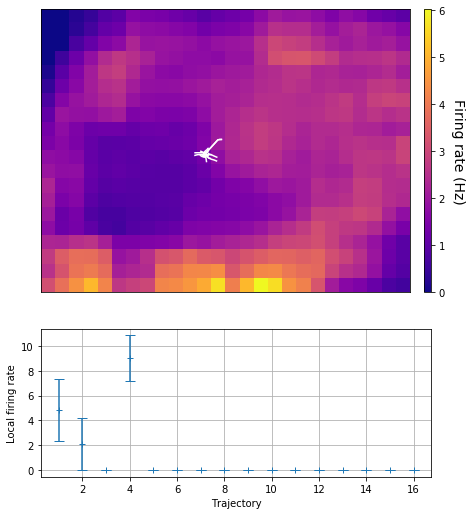

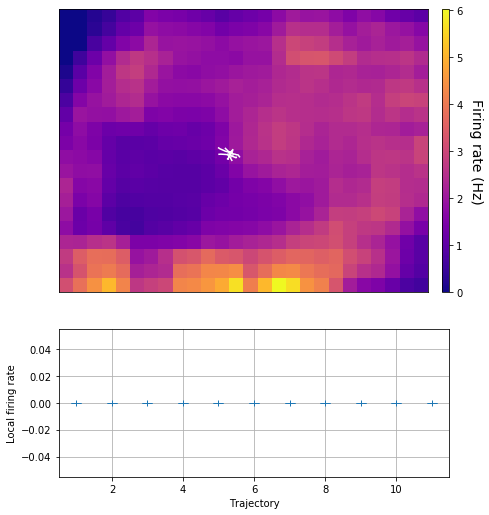

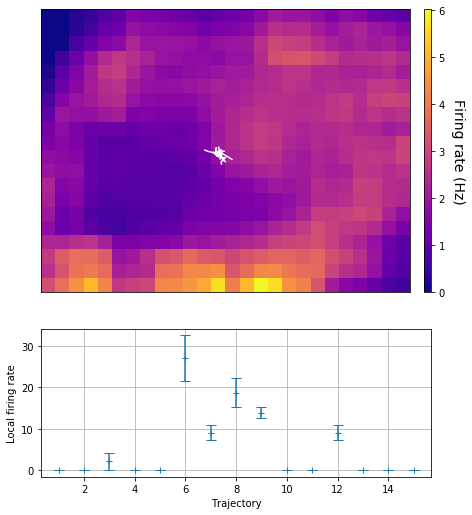

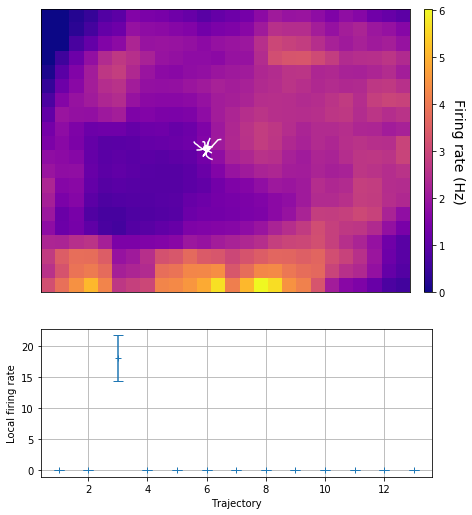

In [17]:
# coherence between units
g = [[]*8]
g[0].append(1)
print(g)

[[1]]
